# Duplicates

@roman 

24 June, 2023

Code to find duplicated properties and delete the ones that are exactly the same as well to add a new property id to uniquely identify each property.

---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import uuid
import os

from scipy.spatial.distance import pdist, squareform


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

---
# Data

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s2.parquet")

# original columns
original_columns = gdf_properties.columns

# to geodataframe
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs='EPSG:4326'
    )

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2232474 entries, 0 to 2259315
Data columns (total 53 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   half_bathrooms                      uint8         
 1   full_bathrooms                      uint8         
 2   property_class_more_common_in_area  string        
 3   neighborhood                        string        
 4   constructor                         string        
 5   zip_code                            uint32        
 6   age_in_months                       uint8         
 7   parking_lots                        uint8         
 8   valuation_date                      datetime64[ns]
 9   potable_water_service_id            float64       
 10  lighting_service_id                 float64       
 11  sidewalk_id                         float64       
 12  project_quality_id                  float64       
 13  property_class_id                   uin

In [4]:
# # subset for testing
# gdf_properties = gdf_properties.sample(100_000)

In [5]:
# see original cols
original_columns

Index(['half_bathrooms', 'full_bathrooms',
       'property_class_more_common_in_area', 'neighborhood', 'constructor',
       'zip_code', 'age_in_months', 'parking_lots', 'valuation_date',
       'potable_water_service_id', 'lighting_service_id', 'sidewalk_id',
       'project_quality_id', 'property_class_id', 'conservation_status_id',
       'controller_id', 'elevator_service_id', 'state_id', 'equipment_id',
       'curb_id', 'infrastructure_service_id', 'road_materials_id',
       'municipality_id', 'grantor_id', 'urban_proximity_id',
       'water_collection_service_id', 'electrical_supply_service_id',
       'telephone_service_supply_id', 'property_type_id',
       'public_transportation_service_id', 'valuation_unit_id',
       'valuation_professional_id', 'latitude', 'longitude', 'level',
       'total_levels', 'purpose_of_appraisal', 'bedrooms', 'built_area',
       'saleable_area', 'land_area', 'rentable_units',
       'rentable_units_subject_property', 'current_use', 'market_pr

---
# Duplicates

## S1: EDA

In [6]:
# unique id's
gdf_properties['property_id'].nunique()

1998607

In [7]:
# get properties with repeated property_id
gdf_repeated_id_avaluo = (
    gdf_properties
    .assign(
        num_id_avaluo=lambda x: x.groupby('property_id')['property_id'].transform('count')
    )
    .query("num_id_avaluo > 1")
    .sort_values(['property_id', 'valuation_date'])
    .copy()
)
gdf_repeated_id_avaluo.shape

(373521, 54)

In [8]:
# see how many propertie
gdf_repeated_id_avaluo['property_id'].nunique()

139654

In [9]:
# how many properties are repeated in avg
gdf_repeated_id_avaluo['property_id'].value_counts().mean()

2.674617268391883

## S2: Spot different properties in same ID

In [10]:
def compare_duplicate(gdf):
    """
    Function that compares the duplicates of a DataFrame with the same property_id.
    It will compare the distance between some columns of the duplicates like the geometry,
    the time and characteristics.
    ---
    Parameters:
    - gdf (Dataframe): The Dataframe of the duplicates.

    Returns:
    - Series: The Series with the comparison.
    """

    return pd.Series({
        'time_delta': gdf['valuation_date'].std().days,
        'saleable_area_dist': gdf['saleable_area'].std(),
        'land_area_dist': gdf['land_area'].std(),
        'price_dist': gdf['price'].std(),
        'bathrooms_dist': gdf['half_bathrooms'].std() + gdf['full_bathrooms'].std(),
        'bedrooms_dist': gdf['bedrooms'].std(),
        'parking_dist': gdf['parking_lots'].std(),
        'num_duplicates': gdf.shape[0]
    })

In [11]:
# compare
df_repeated_stats = (
    gdf_repeated_id_avaluo
    .to_crs('EPSG:6372')  # change to meters in mexico coords
    .groupby('property_id', as_index=False)
    .apply(compare_duplicate, include_groups=False)
)

In [12]:
# see
df_repeated_stats

,property_id,time_delta,saleable_area_dist,land_area_dist,price_dist,bathrooms_dist,bedrooms_dist,parking_dist,num_duplicates
0,0000291c-98bd-53f9-aecb-a94c68d590da,254.0,5.606073,55.448715,20207.259422,0.0,0.0,0.0,3.0
1,00007e17-265b-5a64-8e84-cfbf9f1cc10a,0.0,2.120127,7.782244,18398.369493,0.0,0.0,0.0,8.0
2,0000c9e6-c51e-5893-9836-b7aa8c493d74,137.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
3,0001f723-4fba-5245-8d81-1dc560d63d80,3.0,0.000000,0.000000,146371.103706,0.0,0.0,0.0,2.0
4,000310c5-b5eb-5e4e-aeb9-ad6f329f8868,297.0,0.000000,6.572671,17584.083712,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...
139649,fffe0b65-7d3a-55d3-b370-5dad0900e854,13.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
139650,fffe466b-1b72-553c-afd9-0ea7e976436b,33.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
139651,fffee960-7505-5e07-8348-fe98597a7a29,0.0,0.183847,0.070710,1414.213562,0.0,0.0,0.0,2.0
139652,ffff5d36-d6d9-5498-8ab8-80dfbb091022,19.0,0.000000,0.000000,13856.406461,0.0,0.0,0.0,4.0


In [13]:
# see the distribution of the distances
df_repeated_stats.describe()

,time_delta,saleable_area_dist,land_area_dist,price_dist,bathrooms_dist,bedrooms_dist,parking_dist,num_duplicates
count,139654.000000,139654.000000,139654.000000,1.396540e+05,139654.000000,139654.000000,139654.000000,139654.000000
mean,43.168567,0.976156,3.791627,3.967483e+04,0.021293,0.019079,0.015333,2.674617
std,78.654728,5.343435,27.896101,2.460224e+05,0.142894,0.117030,0.105212,2.689665
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.000000
50%,9.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.000000
75%,49.000000,0.000000,0.007073,2.050610e+04,0.000000,0.000000,0.000000,2.000000
max,1234.000000,408.127899,4626.910645,2.166929e+07,4.242641,3.535534,2.828427,319.000000


In [14]:
# for all dist columns divide by the std
col_dist = df_repeated_stats.columns[df_repeated_stats.columns.str.endswith('_dist')]
col_dist_suffix = [col + '_std' for col in col_dist]
df_repeated_stats[col_dist_suffix] = df_repeated_stats[col_dist].div(df_repeated_stats[col_dist].std())

# see the distribution of the distances
df_repeated_stats[col_dist_suffix].describe()

,saleable_area_dist_std,land_area_dist_std,price_dist_std,bathrooms_dist_std,bedrooms_dist_std,parking_dist_std
count,139654.000000,139654.000000,139654.000000,139654.000000,139654.000000,139654.000000
mean,0.182683,0.135920,0.161265,0.149015,0.163025,0.145737
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000254,0.083351,0.000000,0.000000,0.000000
max,76.379309,165.862270,88.078507,29.690785,30.210554,26.883054


In [15]:
# see the distribution of the distances
df_repeated_stats[col_dist].describe()

,saleable_area_dist,land_area_dist,price_dist,bathrooms_dist,bedrooms_dist,parking_dist
count,139654.000000,139654.000000,1.396540e+05,139654.000000,139654.000000,139654.000000
mean,0.976156,3.791627,3.967483e+04,0.021293,0.019079,0.015333
std,5.343435,27.896101,2.460224e+05,0.142894,0.117030,0.105212
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,0.000000,0.007073,2.050610e+04,0.000000,0.000000,0.000000
max,408.127899,4626.910645,2.166929e+07,4.242641,3.535534,2.828427


count    139654.000000
mean          0.937645
std           3.845488
min           0.000000
25%           0.000000
50%           0.003042
75%           0.337887
max         180.939062
Name: total_distance, dtype: float64


<Axes: ylabel='Frequency'>

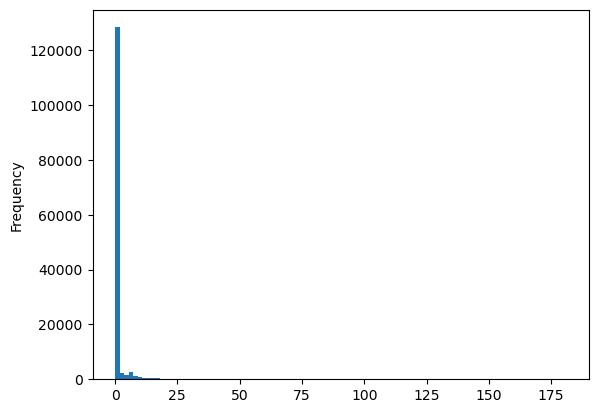

In [16]:
# get total distance
df_repeated_stats['total_distance'] = df_repeated_stats[col_dist_suffix].sum(axis=1)

# see the distribution of the distances
print(df_repeated_stats['total_distance'].describe())
df_repeated_stats['total_distance'].plot.hist(bins=100)


In [17]:
# see how many properties have little distance
mask = df_repeated_stats['total_distance'].le(0)

# same property_id
print("same id avaluo")
print(mask.sum())
print(mask.mean())

# sum properties
print("\ntotal properties")
print(df_repeated_stats.loc[mask ,'num_duplicates'].sum())
print(df_repeated_stats.loc[mask ,'num_duplicates'].sum() / gdf_properties.shape[0])

same id avaluo
66157
0.4737207670385381

total properties
139089.0
0.062302629280341006


<Axes: xlabel='total_distance', ylabel='Count'>

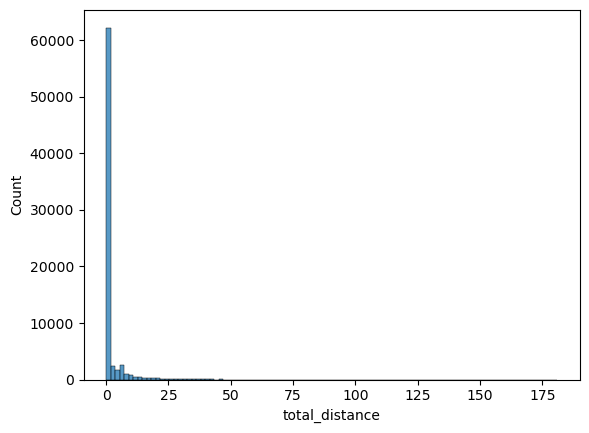

In [18]:
# see distribution of distance
sns.histplot(df_repeated_stats.query("total_distance > 0")['total_distance'], bins=100)

In [19]:
# see deciles of distance
median_total_distance = df_repeated_stats['total_distance'].median()
df_repeated_stats['total_distance'].quantile(np.linspace(0, 1, 11))

0.0      0.000000
0.1      0.000000
0.2      0.000000
0.3      0.000000
0.4      0.000000
0.5      0.003042
0.6      0.063231
0.7      0.198317
0.8      0.497892
0.9      1.308706
1.0    180.939062
Name: total_distance, dtype: float64

## S3: Flag duplicates

In [20]:
# flag duplicates
df_repeated_stats = (
    df_repeated_stats
    .assign(
        flag_duplicate_total_dist=lambda x: (
            x['total_distance'].gt(median_total_distance)
        ).astype(int),
        flag_time=lambda x: (
            x['total_distance'].le(median_total_distance)
            & x['time_delta'].gt(0)
        ).astype(int),
        flag_heuristic=lambda x: (
            ~(
                x['bedrooms_dist'].le(0)
                & x['saleable_area_dist'].le(5)
                & x['land_area_dist'].le(10)
            )
        ).astype(int),
        has_flag=lambda x: (
            x['flag_time']
            | x['flag_heuristic']
            | x['flag_duplicate_total_dist']
            )
    )
)
df_repeated_stats

,property_id,time_delta,saleable_area_dist,land_area_dist,price_dist,bathrooms_dist,bedrooms_dist,parking_dist,num_duplicates,saleable_area_dist_std,land_area_dist_std,price_dist_std,bathrooms_dist_std,bedrooms_dist_std,parking_dist_std,total_distance,flag_duplicate_total_dist,flag_time,flag_heuristic,has_flag
0,0000291c-98bd-53f9-aecb-a94c68d590da,254.0,5.606073,55.448715,20207.259422,0.0,0.0,0.0,3.0,1.049151,1.987687,0.082136,0.0,0.0,0.0,3.118974,1,0,1,1
1,00007e17-265b-5a64-8e84-cfbf9f1cc10a,0.0,2.120127,7.782244,18398.369493,0.0,0.0,0.0,8.0,0.396772,0.278972,0.074783,0.0,0.0,0.0,0.750528,1,0,0,1
2,0000c9e6-c51e-5893-9836-b7aa8c493d74,137.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0,1,0,1
3,0001f723-4fba-5245-8d81-1dc560d63d80,3.0,0.000000,0.000000,146371.103706,0.0,0.0,0.0,2.0,0.000000,0.000000,0.594950,0.0,0.0,0.0,0.594950,1,0,0,1
4,000310c5-b5eb-5e4e-aeb9-ad6f329f8868,297.0,0.000000,6.572671,17584.083712,0.0,0.0,0.0,5.0,0.000000,0.235613,0.071474,0.0,0.0,0.0,0.307086,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139649,fffe0b65-7d3a-55d3-b370-5dad0900e854,13.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0,1,0,1
139650,fffe466b-1b72-553c-afd9-0ea7e976436b,33.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0,1,0,1
139651,fffee960-7505-5e07-8348-fe98597a7a29,0.0,0.183847,0.070710,1414.213562,0.0,0.0,0.0,2.0,0.034406,0.002535,0.005748,0.0,0.0,0.0,0.042689,1,0,0,1
139652,ffff5d36-d6d9-5498-8ab8-80dfbb091022,19.0,0.000000,0.000000,13856.406461,0.0,0.0,0.0,4.0,0.000000,0.000000,0.056322,0.0,0.0,0.0,0.056322,1,0,0,1


<Axes: ylabel='Frequency'>

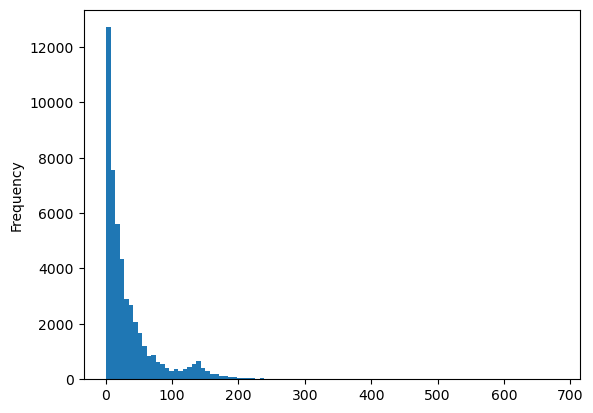

In [21]:
# see some flag_time
(
    df_repeated_stats
    .query("flag_time == 1")
    ['time_delta']
    .plot.hist(bins=100)
    )

In [22]:
# counts
df_repeated_stats.filter(like='flag').mean().sort_values()

flag_heuristic               0.126921
flag_time                    0.350337
flag_duplicate_total_dist    0.499971
has_flag                     0.850309
dtype: float64

In [23]:
# join with gdf_properties
gdf_properties2 = (
    gdf_properties
    .merge(
        df_repeated_stats,
        how='left',
        on='property_id'
        )
    .assign(has_flag=lambda x: x['has_flag'].fillna(np.nan))
)
print(f"Total properties: {gdf_properties2.shape[0]}")


Total properties: 2232474


## S4: Subset Unique & Not Unique Properties

### Partition

In [24]:
# subset by flags and not flags
gdf_unique_properties = gdf_properties2.query("has_flag.isna()").copy()
gdf_properties_not_flag = gdf_properties2.query("has_flag.eq(0)").copy()
gdf_properties_flag = gdf_properties2.query("has_flag.eq(1)").copy()
print(f"Flag properties: {gdf_properties_flag.shape[0]}")
print(f"Not flag properties: {gdf_properties_not_flag.shape[0]}")

Flag properties: 328581
Not flag properties: 44940


### Flagged

In [25]:
# flag time
gdf_properties_flag_time = (
    gdf_properties_flag
    .query("flag_time.eq(1)")
    .sort_values('valuation_date', ascending=True)
    .groupby('property_id')
    # the way to handle duplicates of time
    .last()
    .reset_index()
)
print(f"Flag time properties before: {gdf_properties_flag.query('flag_time.eq(1)').shape[0]}")
print(f"Flag time properties after: {gdf_properties_flag_time.shape[0]}")


Flag time properties before: 104284
Flag time properties after: 48926


In [26]:
# instantiate rng
rng = np.random.default_rng(42)

# flag duplicate total dist or flag heuristic
gdf_properties_flag_not_time = (
    gdf_properties_flag
    .sort_values(['property_id'])
    .query("flag_time.eq(0)")  # the complement
    .assign(
        # sub-id: concat longitude, latitude, valuation_date, saleable_area, price
        sub_id=lambda x: (
            x['saleable_area'].div(5).round(0).mul(5).astype(str) + '-'
            + x['bedrooms'].astype(str) + '-'
            + x['land_area'].div(10).round(0).mul(10).astype(str) + '-'
        ),
        # generate random id using a normal distribution
        random_id=lambda x: rng.normal(size=x.shape[0])
    )
    .sort_values(['property_id', 'random_id'])
    # get a random obs
    .groupby(['property_id', 'sub_id'], as_index=False)
    .last()
)

print(f"Flag not time properties before: {gdf_properties_flag.query('flag_time.eq(0)').shape[0]}")
print(f"Flag not time after: {gdf_properties_flag_not_time.shape[0]}")
gdf_properties_flag_not_time

Flag not time properties before: 224297
Flag not time after: 112098


,property_id,sub_id,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,geometry,time_delta,saleable_area_dist,land_area_dist,price_dist,bathrooms_dist,bedrooms_dist,parking_dist,num_duplicates,saleable_area_dist_std,land_area_dist_std,price_dist_std,bathrooms_dist_std,bedrooms_dist_std,parking_dist_std,total_distance,flag_duplicate_total_dist,flag_time,flag_heuristic,has_flag,random_id
0,0000291c-98bd-53f9-aecb-a94c68d590da,60.0-2-20.0-,0,1,3,TIXCACAL,SADASI,97312,0,1,2021-10-29,1.0,3.0,1.0,1.0,3,6,b1443922-960e-485e-acf7-e6c1b2a25c6c,2.0,31,2,1.0,3,3,050,98013144-6a9f-4e08-9255-cb54568d2f5a,3,1.0,2.0,2.0,4,1.0,73c93293-e9b5-4953-aae4-7a18a74a651c,74bc5110-b09e-43da-8ce6-d44224453354,20.935277,-89.706799,4,1,S/D,2,59.259998,61.700001,20.980000,4.0,1.0,DEPARTAMENTO EN CONDOMINIO,481277.0,481000.0,367459.26,19511.8196,A TRAVES DEL ANILLO PERIFERICO PONIENTE AV. 51...,60,aa98ccb1-dad0-41a1-9243-f220819887f7,POINT (-89.70680 20.93528),254.0,5.606073,55.448715,20207.259422,0.0,0.0,0.0,3.0,1.049151,1.987687,0.082136,0.0,0.0,0.0,3.118974,1.0,0.0,1.0,1.0,-1.039984
1,0000291c-98bd-53f9-aecb-a94c68d590da,70.0-2-120.0-,0,1,3,TIXCACAL,SADASI,97312,0,1,2020-08-12,1.0,3.0,1.0,1.0,3,6,b1443922-960e-485e-acf7-e6c1b2a25c6c,2.0,31,2,1.0,3,6,050,98013144-6a9f-4e08-9255-cb54568d2f5a,3,1.0,2.0,2.0,4,1.0,73c93293-e9b5-4953-aae4-7a18a74a651c,74bc5110-b09e-43da-8ce6-d44224453354,20.935277,-89.706799,3,1,S/D,2,59.259998,71.410004,117.019997,4.0,1.0,DEPARTAMENTO EN CONDOMINIO,516257.0,516000.0,396914.46,106652.0280,A TRAVES DEL ANILLO PERIFERICO PONIENTE AV. 51...,60,2e28a417-020f-4f39-9562-c6b3315bd137,POINT (-89.70680 20.93528),254.0,5.606073,55.448715,20207.259422,0.0,0.0,0.0,3.0,1.049151,1.987687,0.082136,0.0,0.0,0.0,3.118974,1.0,0.0,1.0,1.0,0.750451
2,00007e17-265b-5a64-8e84-cfbf9f1cc10a,45.0-2-20.0-,0,1,3,FRACCIONAMIENTO ALTURAS DEL SUR ETAPA XIV CATORCE,URBANIZADORA LEY DEL PACIFICO,80295,0,1,2020-09-04,NaN,NaN,NaN,NaN,3,6,5c37c2ac-b6a4-448d-8f34-bbf19a3c1589,2.0,25,3,NaN,3,6,006,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,4,NaN,75fe9a3c-92a0-4623-925b-955a08effd0c,e4805cb2-b443-4c48-90b8-636e1860e6b8,24.755000,-107.348056,6,1,S/D,2,41.880001,42.770000,21.379999,NaN,NaN,<NA>,374451.0,374000.0,253772.00,38484.0000,<NA>,60,b73fcdb8-4954-42bc-83f1-f7d1b6ffc5f1,POINT (-107.34806 24.75500),0.0,2.120127,7.782244,18398.369493,0.0,0.0,0.0,8.0,0.396772,0.278972,0.074783,0.0,0.0,0.0,0.750528,1.0,0.0,0.0,1.0,0.879398
3,00007e17-265b-5a64-8e84-cfbf9f1cc10a,45.0-2-30.0-,0,1,3,FRACCIONAMIENTO ALTURAS DEL SUR ETAPA XIV CATORCE,URBANIZADORA LEY DEL PACIFICO,80295,0,1,2020-09-04,NaN,NaN,NaN,NaN,3,6,5c37c2ac-b6a4-448d-8f34-bbf19a3c1589,2.0,25,3,NaN,3,6,006,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,4,NaN,75fe9a3c-92a0-4623-925b-955a08effd0c,e4805cb2-b443-4c48-90b8-636e1860e6b8,24.755000,-107.348056,4,1,S/D,2,46.369999,47.349998,27.920000,NaN,NaN,<NA>,397219.0,397000.0,280964.00,50256.0000,<NA>,60,c737ae1b-bc28-427c-aff4-d04f2c9201be,POINT (-107.34806 24.75500),0.0,2.120127,7.782244,18398.369493,0.0,0.0,0.0,8.0,0.396772,0.278972,0.074783,0.0,0.0,0.0,0.750528,1.0,0.0,0.0,1.0,0.940565
4,00007e17-265b-5a64-8e84-cfbf9f1cc10a,45.0-2-40.0-,0,1,3,FRACCIONAMIENTO ALTURAS DEL SU

### Not-Flagged

In [27]:
# instantiate rng
rng = np.random.default_rng(8)

# get on property randomly
gdf_properties_not_flag = (
    gdf_properties_not_flag
    # generate random id using a normal distribution
    .assign(random_id=lambda x: rng.normal(size=x.shape[0]))
    .sort_values(['property_id', 'random_id'])
    .groupby('property_id', as_index=False)
    .last()    
)
print(f"Not flag properties after: {gdf_properties_not_flag.shape[0]}")

Not flag properties after: 20905


### Concatenate

In [28]:
# saved properties
num_saved = (
    gdf_properties_not_flag.shape[0]
    + gdf_properties_flag_time.shape[0]
    + gdf_properties_flag_not_time.shape[0]
)

print(f"Total saved properties: {num_saved}")

Total saved properties: 181929


In [29]:
# concat
gdf_properties3 = (
    pd.concat(
        [
            # good properties
            gdf_unique_properties,
            # properties repeated without disterences
            gdf_properties_not_flag, 
            # properties repeated with disterences
            gdf_properties_flag_time, gdf_properties_flag_not_time
        ],
        ignore_index=True
        )
)
print(f"Flag properties: {gdf_properties3.shape[0]}")
print(f"Perc properties eliminated: {1 - gdf_properties3.shape[0] / gdf_properties.shape[0]}")

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Flag properties: 2040882
Perc properties eliminated: 0.08582048435950429


In [30]:
# nunique
print(gdf_properties3['property_id'].nunique())
print(gdf_properties3.shape[0])


1998607
2040882


In [31]:
# look for duplicates
gdf_properties3['new_num_duplicates'] = gdf_properties3.groupby('property_id')['property_id'].transform('count')

# see if there are duplicates
(
    gdf_properties3
    .query("new_num_duplicates > 1")
    .sort_values(['new_num_duplicates', 'property_id'], ascending=[False, True])
    .query("property_id.eq('18e27699-a0d1-5ecb-88ca-35b4d6bae7d8')", engine='python')
    .reset_index(drop=True)
    )


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,geometry,time_delta,saleable_area_dist,land_area_dist,price_dist,bathrooms_dist,bedrooms_dist,parking_dist,num_duplicates,saleable_area_dist_std,land_area_dist_std,price_dist_std,bathrooms_dist_std,bedrooms_dist_std,parking_dist_std,total_distance,flag_duplicate_total_dist,flag_time,flag_heuristic,has_flag,random_id,sub_id,new_num_duplicates
0,1,2,5,SAN FRANCISCO COACALCO,PROMOTORA FM,55712,0,2,2020-06-09,NaN,NaN,NaN,NaN,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,NaN,3,2,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,10,1,S/D,3,122.980003,122.980003,126.449997,NaN,NaN,<NA>,4314000.0,4314000.0,1844700.00,733410.0,<NA>,80,9e24210b-0262-4528-8d37-3d053fc5ee2a,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),321.0,14.939191,13.209404,480498.731613,0.459436,0.246775,0.257103,239.0,2.795803,0.473522,1.953069,3.215221,2.108653,2.443656,12.989923,1.0,0.0,1.0,1.0,0.146848,125.0-3-130.0-,28
1,1,2,5,SAN FRANCISCO COACALCO,NO APLICA,55712,0,2,2019-08-01,1.0,2.0,1.0,1.0,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,1.0,3,3,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,1.0,2.0,2.0,4,1.0,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,11,1,S/D,3,122.980003,122.980003,84.889999,60.0,1.0,DEPARTAMENTO EN CONDOMINIO,3640000.0,3640000.0,1844700.00,449917.0,AL NORTE SE ENCUENTRA AVENIDA DE ALTA TENSION....,80,50da2e56-8ac4-45f6-8476-01fe274edbaf,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),321.0,14.939191,13.209404,480498.731613,0.459436,0.246775,0.257103,239.0,2.795803,0.473522,1.953069,3.215221,2.108653,2.443656,12.989923,1.0,0.0,1.0,1.0,-0.390922,125.0-3-80.0-,28
2,1,2,5,SAN FRANCISCO COACALCO,PROMOTORA FM,55712,0,2,2020-06-09,NaN,NaN,NaN,NaN,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,NaN,3,2,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,10,1,S/D,3,131.539993,131.539993,135.009995,NaN,NaN,<NA>,4442000.0,4442000.0,1973100.00,783058.0,<NA>,80,c9a60391-c5fe-47cf-b9db-5caf28305d26,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),321.0,14.939191,13.209404,480498.731613,0.459436,0.246775,0.257103,239.0,2.795803,0.473522,1.953069,3.215221,2.108653,2.443656,12.989923,1.0,0.0,1.0,1.0,0.091541,130.0-3-140.0-,28
3,1,3,5,SAN FRANCISCO COACALCO COSMOPOL,PROMOTORA FM,55712,0,4,2021-11-26,NaN,NaN,NaN,NaN,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,NaN,3,2,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,18,1,S/D,3,131.699997,131.699997,83.010002,NaN,NaN,<NA>,4544000.0,4544000.0,1981821.60,439953.0,<NA>,80,9cb73156-1929-4f02-81ca-13658c95e11c,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),321.0,14.939191,13.209404,480498.731613,0.459436,0.246775,0.257103,239.0,2.795803,0.473522,1.953069,3.215221,2.108653,2.443656,12.989923,1.0,0.0,1.0,1.0,1.086084,130.0-3-80.0-,28
4,

---
# Save

In [34]:
# subset
gdf_properties3 = gdf_properties3[original_columns]

# save
os.makedirs("../../data/interim", exist_ok=True)
gdf_properties3.to_parquet("../../data/interim/cleaned_data_s3.parquet")

---
# Sandbox

In [35]:
# see null columns
gdf_properties.isnull().sum()[gdf_properties.isnull().sum().gt(0)]

neighborhood                           153
constructor                           3053
potable_water_service_id            754220
lighting_service_id                 754193
sidewalk_id                         760943
project_quality_id                  770960
elevator_service_id                 103303
curb_id                             754193
water_collection_service_id         754193
electrical_supply_service_id        754193
telephone_service_supply_id         754193
public_transportation_service_id    754193
rentable_units                      315512
rentable_units_subject_property     770955
current_use                         764003
access_routes                       754250
dtype: int64

In [36]:
# count of unique values
gdf_repeated_id_avaluo['property_id'].value_counts()

property_id
e53135c9-dcf8-5cd2-9b66-689e536ab6c3    319
18e27699-a0d1-5ecb-88ca-35b4d6bae7d8    239
77b3182c-edd9-5b1b-93dc-bf96f7c4fd3b    202
365c430e-13f8-51d7-b964-bd10723edf86    188
0fa57e0a-a526-563d-aab8-9f7b2acc3768    141
                                       ... 
ead58102-f160-5bd5-8cf9-43618305b0c8      2
ead4d5f5-376b-5f46-a7f8-cedfc7bfa521      2
b8ad7dfa-4e29-587a-846b-4c96c2304bda      2
b8b23589-78ab-57e2-a0ae-d6c0ce5d1e9e      2
ffffb4b0-2bc2-50b4-b9ea-9a6a58a9d58a      2
Name: count, Length: 139654, dtype: Int64

In [37]:
# see some repeated id 18e27699-a0d1-5ecb-88ca-35b4d6bae7d8
(
    gdf_repeated_id_avaluo
    .query("property_id.eq('18e27699-a0d1-5ecb-88ca-35b4d6bae7d8')", engine='python')
    .reset_index(drop=True)
    
    )

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,geometry,num_id_avaluo
0,0,2,5,SAN FRANCISCO COACALCO,NO APLICA,55712,0,2,2019-04-09,1.0,2.0,1.0,1.0,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,1.0,3,3,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,1.0,2.0,2.0,4,1.0,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,13,1,S/D,2,70.860001,70.860001,52.779999,60.0,1.0,DEPARTAMENTO EN CONDOMINIO,2218000.0,2218000.0,1062900.00,279734.0,AL NORTE SE ENCUENTRA AVENIDA DE ALTA TENSION....,80,e2578f70-a830-4e5c-820b-be42adb8955c,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),239
1,0,2,5,SAN FRANCISCO COACALCO,NO APLICA,55712,0,2,2019-04-09,1.0,2.0,1.0,1.0,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,1.0,3,3,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,1.0,2.0,2.0,4,1.0,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,17,1,S/D,2,70.860001,70.860001,49.709999,60.0,1.0,DEPARTAMENTO EN CONDOMINIO,2299000.0,2299000.0,1062900.00,263463.0,AL NORTE SE ENCUENTRA AVENIDA DE ALTA TENSION....,80,b82e46c7-0686-4de0-95b7-8cc0a6e17a18,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),239
2,0,2,5,SAN FRANCISCO COACALCO,NO APLICA,55712,0,2,2019-04-10,1.0,2.0,1.0,1.0,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,1.0,3,3,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,1.0,2.0,2.0,4,1.0,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,8,1,S/D,2,73.930000,73.930000,54.130001,60.0,1.0,DEPARTAMENTO EN CONDOMINIO,2194000.0,2194000.0,1108950.00,286889.0,AL NORTE SE ENCUENTRA AVENIDA DE ALTA TENSION....,80,835ef04d-109d-462e-a85b-6e70ccd8f220,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),239
3,0,2,5,SAN FRANCISCO COACALCO,NO APLICA,55712,0,2,2019-04-10,1.0,2.0,1.0,1.0,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,1.0,3,3,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,1.0,2.0,2.0,4,1.0,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,13,1,S/D,2,70.860001,70.860001,52.779999,60.0,1.0,DEPARTAMENTO EN CONDOMINIO,2218000.0,2218000.0,1062900.00,279734.0,AL NORTE SE ENCUENTRA AVENIDA DE ALTA TENSION....,80,2163f7ed-d163-4100-b7ad-458807fe7229,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),239
4,0,2,5,SAN FRANCISCO COACALCO,NO APLICA,55712,0,2,2019-04-25,1.0,2.0,1.0,1.0,5,6,fd2af73c-9d27-4c8c-bdef-a94a0ea9c3d8,0.0,15,1,1.0,3,3,020,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,1.0,2.0,2.0,4,1.0,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,2122b66a-19ee-4503-b2df-8ec23fa92818,19.634667,-99.125306,6,1,S/D,2,59.150002,59.150002,45.470001,60.0,1.0,DEPARTAMENTO EN CONDOMINIO,1786000.0,1786000.0,887250.00,240991.0,AL NORTE SE ENCUENTRA AVENIDA DE ALTA TENSION....,80,3ef9657e-ac1f-4d6c-a4a8-dcb46584c040,18e27699-a0d1-5ecb-88ca-35b4d6bae7d8,POINT (-99.12531 19.63467),239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,1,3,5,SAN FRANCISCO COACALCO COSMOPOL,PROMOTORA FM,55712,0,4,2